# Tracking using image features

Testing the Elliptical Fourier Descriptors (EFD) similarity between instances of cells

In [1]:
import dask.array as da
import napari
import btrack
from tqdm.auto import tqdm
import skimage
from skimage.io import imshow,  imsave
import matplotlib.pyplot as plt
import numpy as np
from pyefd import elliptic_fourier_descriptors
plt.rcParams["figure.figsize"] = (15,7)

### Load images from zarr and compress into max projections

In [2]:
gfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch1.zarr/')
rfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch2.zarr/')
gfp = da.sum(gfp, axis = 1, dtype='u2')
rfp = da.sum(rfp, axis = 1, dtype='u2')
masks = da.from_zarr(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch99.zarr/',)# chunks = gfp.chunks)

#### Compress into multichannel image for btrack

In [3]:
image = da.stack([gfp, rfp], axis = -1)
image

,Array,Chunk
Bytes,10.22 GiB,8.90 MiB
Shape,"(75, 6048, 6048, 2)","(1, 2160, 2160, 1)"
Count,10802 Tasks,1350 Chunks
Type,uint16,numpy.ndarray


## Define features

In [4]:
FEATURES = [
  "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "solidity",
  "mean_intensity",
    "intensity_image"
]

In [5]:
objects = btrack.utils.segmentation_to_objects(
    masks, 
    image,
    properties = tuple(FEATURES),
    use_weighted_centroid = False, 
    track_progress = True
)

[INFO][2022/11/10 03:39:46 PM] Localizing objects from segmentation...
[INFO][2022/11/10 03:39:46 PM] Found intensity_image data


  0%|          | 0/75 [00:00<?, ?it/s]

[INFO][2022/11/10 03:54:53 PM] Objects are of type: <class 'dict'>
[INFO][2022/11/10 03:54:54 PM] ...Found 69608 objects in 75 frames.


In [6]:
stop

NameError: name 'stop' is not defined

#### Checking featuers were measured

In [ ]:
objects[0]

In [ ]:
### finding the EFD
for obj in tqdm(objects):
    ### extract the intensity image (1ch only)
    glimpse = obj.properties['intensity_image'][0]
    ### pad the glimpse to ensure only one object is identifiable
    glimpse = np.pad(glimpse, pad_width = 1)
    ### find the contours (zero because only one object)
    contours = skimage.measure.find_contours(glimpse, fully_connected='high', level = 0.5)[0]
    ### get the efd
    efd = elliptic_fourier_descriptors(contours, order=100, normalize=True)
#     obj.properties = {'efd': efd}
    flatten_efd = efd.flatten()
    obj.properties = {'efd flat': flatten_efd}

## Remove intensity image from objects 

btrack does not handle 2d arrays in objects

In [ ]:
for obj in tqdm(objects):
    obj.properties.pop('intensity_image')

In [ ]:
objects[0]

## Track

In [ ]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file(
        '/home/dayn/analysis/BayesianTracker/models/particle_config.json'
    )
    tracker.verbose = True

    tracker.max_search_radius = 400
    
    # use visual features to track
    tracker.features = FEATURES
    
    # append the objects to be tracked
    tracker.append(objects)

    # set the volume
    tracker.volume=((0, 6048), (0, 6048), (-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=25)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

#     ?tracker.export(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5', obj_type='obj_type_1')

#     # get the tracks in a format for napari visualization (optional)
#     visualise_tracks, properties, graph = tracker.to_napari(ndim=2)
    
    tracks = tracker.tracks

In [ ]:
tracks[100]

In [ ]:
print(tracks[0].properties['area'])

In [ ]:
plt.hist([len(track) for track in tracks])

In [ ]:
len([len(track) for track in tracks if len(track) > 15])

In [ ]:
plt.hist([len(track) for track in tracks if len(track) > 7])

### Filter tracks

In [ ]:
tracks_filt = [track for track in tracks if len(track) > 15]
visualise_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks_filt, ndim = 2)

In [ ]:
visualise_raw_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim = 2)

In [ ]:
viewer = napari.Viewer()
viewer.add_image(gfp, name="gfp", 
                 #contrast_limits=[0,255],
                 blending = 'additive', colormap = 'green')
# viewer.add_image(rfp, name="rfp", 
#                 # contrast_limits=[0,55], 
#                  blending = 'additive', colormap = 'magenta')
viewer.add_labels(masks, name = 'masks')
viewer.add_tracks(visualise_tracks, name = 'tracks_filtered')
viewer.add_tracks(visualise_raw_tracks, name = 'tracks')


### Inspecting one track (ID == 88)

In [ ]:
objects[0]

In [ ]:
[track for track in tracks if track.ID == 2373][0]

In [ ]:
track_88 = [track for track in tracks if track.ID == 579][0]

In [ ]:
track_88

In [ ]:
plt.plot(track_88.properties['area'])

### Inspecting one track (ID == 30)

In [ ]:
track_30 = [track for track in tracks if track.ID == 30][0]

In [ ]:
track_30

In [ ]:
plt.plot(track_30.properties['area'])

### Now doing on the whole FOV

In [ ]:
gfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch1.zarr/')
rfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch2.zarr/')
gfp = da.sum(gfp, axis = 1, dtype='u2')
rfp = da.sum(rfp, axis = 1, dtype='u2')
masks = da.from_zarr(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch99.zarr/',)# chunks = gfp.chunks)

In [ ]:
FEATURES = [
  "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "solidity",
  "mean_intensity",
]

In [ ]:
%%time

objects = btrack.utils.segmentation_to_objects(
    masks, 
    gfp,
    properties = tuple(FEATURES), 
)

In [ ]:
objects[0]

In [ ]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file(
        '/home/dayn/analysis/BayesianTracker/models/test_config.json'
    )
    tracker.verbose = True

    tracker.max_search_radius = 400
    
    # use visual features to track
    tracker.features = FEATURES
    
    # append the objects to be tracked
    tracker.append(objects)

    # set the volume
    tracker.volume=((0, 6048), (0, 6048), (-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=25)

    # generate hypotheses and run the global optimizer
    tracker.optimize()
    
    # store config
    cfg = tracker.configuration

    tracker.export(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5', obj_type='obj_type_1')

    # get the tracks in a format for napari visualization (optional)
    visualise_tracks, properties, graph = tracker.to_napari(ndim=2)
    
    tracks = tracker.tracks

In [ ]:
tracks

New config

In [ ]:
np.nanmean([len(track) for track in tracks if len(track)>30])

In [ ]:
plt.hist([len(track) for track in tracks if len(track)>30])

Previous config (default particle track)

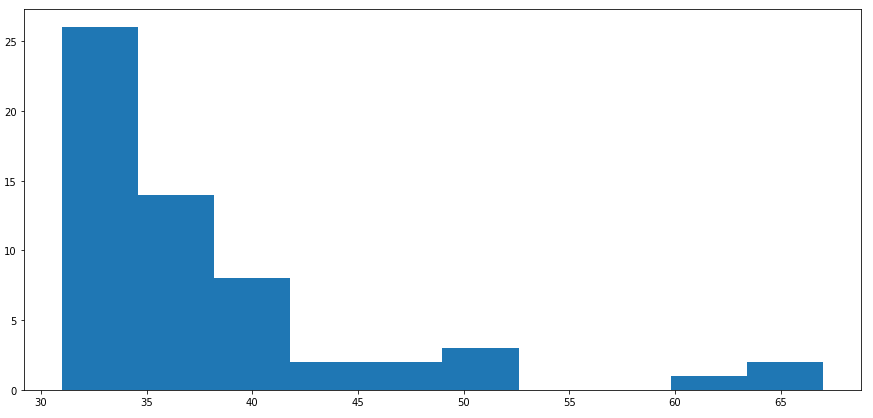

checking dummies

In [ ]:
track_5603 = [track for track in tracks if track.ID ==5603][0]
track_5603

### Filter tracks

In [ ]:
tracks_filt = [track for track in tracks if len(track) > 30]
visualise_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks_filt, ndim = 2)

In [ ]:
viewer = napari.Viewer()
viewer.add_image(gfp, name="gfp", 
                 #contrast_limits=[0,255],
                 blending = 'additive', colormap = 'green')
# viewer.add_image(rfp, name="rfp", 
#                 # contrast_limits=[0,55], 
#                  blending = 'additive', colormap = 'magenta')
viewer.add_labels(masks, name = 'masks')
viewer.add_tracks(visualise_tracks, name = 'tracks_filtered')

#### Inspecting the longest track

In [ ]:
import numpy as np

In [ ]:
sorted([(len(track), track.ID) for track in tracks if len(track)>30])

In [ ]:
track_5603 = [track for track in tracks if track.ID ==5603][0]

In [ ]:
track_5603